In [1]:
import pandas as pd
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [2]:
# Load the training and testing CSV files
train_df = pd.read_csv("filtered_training.csv")
test_df = pd.read_csv("filtered_testing.csv")

# Display basic information about the dataset
print("Training Data")
print(train_df.head())
print("\nTesting Data")
print(test_df.head())


Training Data
   Unnamed: 0                path  label  \
0           0  training/398/0.wav      3   
1           1  training/398/1.wav      3   
2           2  training/398/2.wav      3   
3           3  training/398/3.wav      3   
4           4  training/398/4.wav      3   

                                       youtube title  \
0  US Army, NATO. Powerful M1A2 Abrams and TR-85 ...   
1  US Army, NATO. Powerful M1A2 Abrams and TR-85 ...   
2  US Army, NATO. Powerful M1A2 Abrams and TR-85 ...   
3  US Army, NATO. Powerful M1A2 Abrams and TR-85 ...   
4  US Army, NATO. Powerful M1A2 Abrams and TR-85 ...   

                                        youtube url  video_num  file_id  \
0  https://www.youtube.com/watch?v=Oh4q6ck6ufc&t=1s        398        0   
1  https://www.youtube.com/watch?v=Oh4q6ck6ufc&t=1s        398        1   
2  https://www.youtube.com/watch?v=Oh4q6ck6ufc&t=1s        398        2   
3  https://www.youtube.com/watch?v=Oh4q6ck6ufc&t=1s        398        3   
4  https:

In [3]:
# Check the unique label classes
unique_labels = train_df['label'].unique()
print("Unique labels:", unique_labels)

# Check the number of unique label classes
num_classes = len(unique_labels)
print("Number of classes:", num_classes)

# Alternatively, you can also see the distribution of classes
label_counts = train_df['label'].value_counts()
print("Class distribution:\n", label_counts)


Unique labels: [3 4 0 2 1 6 5]
Number of classes: 7
Class distribution:
 label
1    1165
4     883
5     871
3     819
6     815
2     732
0     720
Name: count, dtype: int64


In [4]:
# Check the unique label classes
unique_labels = test_df['label'].unique()
print("Unique labels:", unique_labels)

# Check the number of unique label classes
num_classes = len(unique_labels)
print("Number of classes:", num_classes)

# Alternatively, you can also see the distribution of classes
label_counts = test_df['label'].value_counts()
print("Class distribution:\n", label_counts)


Unique labels: [6 2 0 1 3 4 5]
Number of classes: 7
Class distribution:
 label
1    262
0    203
6    129
4    108
2     98
3     84
5     76
Name: count, dtype: int64


In [5]:
# Calculate duration for each audio sample
train_df['duration'] = train_df['End_time'] - train_df['Start_time']

# Calculate average duration for each class
avg_duration_per_class = train_df.groupby('label')['duration'].mean()
print("Average duration per class:\n", avg_duration_per_class)


Average duration per class:
 label
0    5.543056
1    4.762232
2    5.086066
3    4.007326
4    5.715742
5    6.740528
6    6.368098
Name: duration, dtype: float64


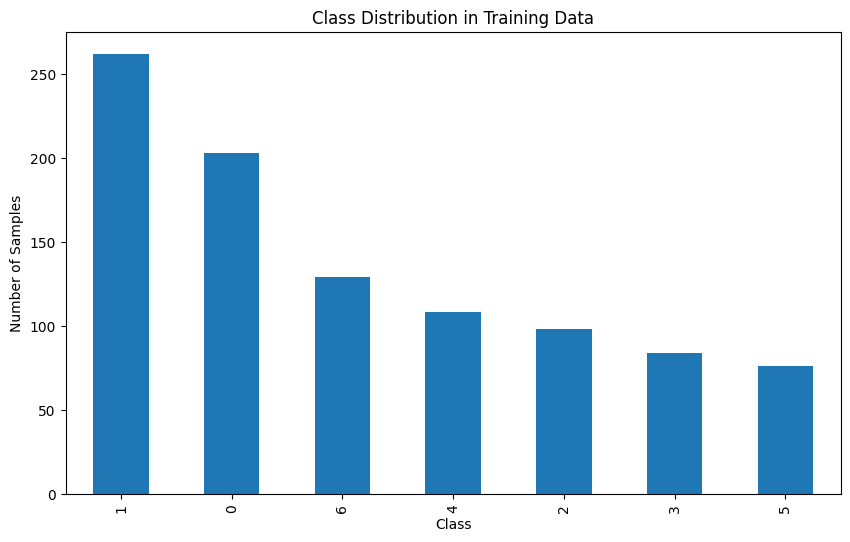

In [6]:
# Plot class distribution
label_counts.plot(kind='bar', figsize=(10, 6))
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

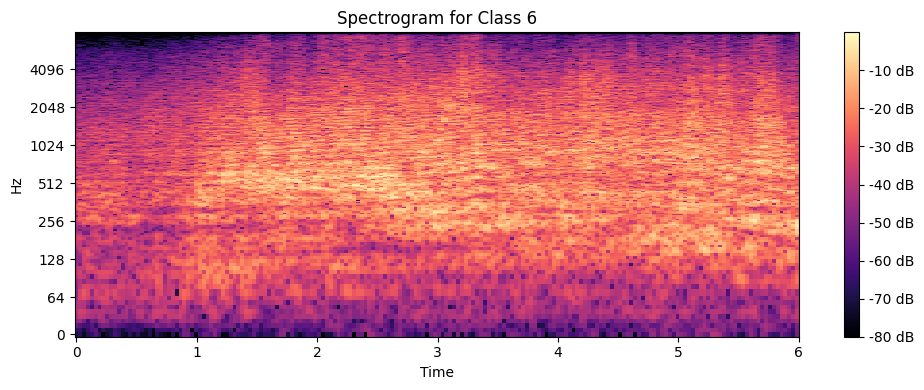

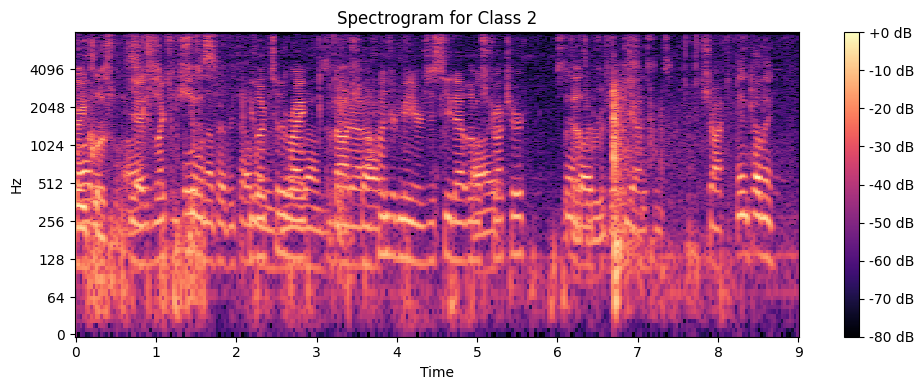

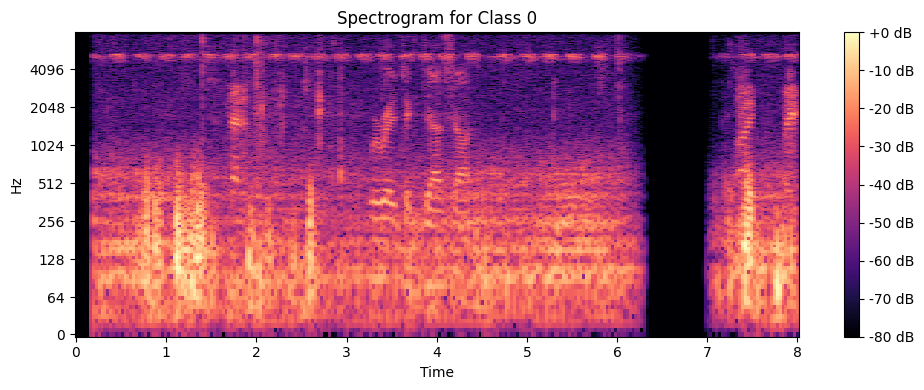

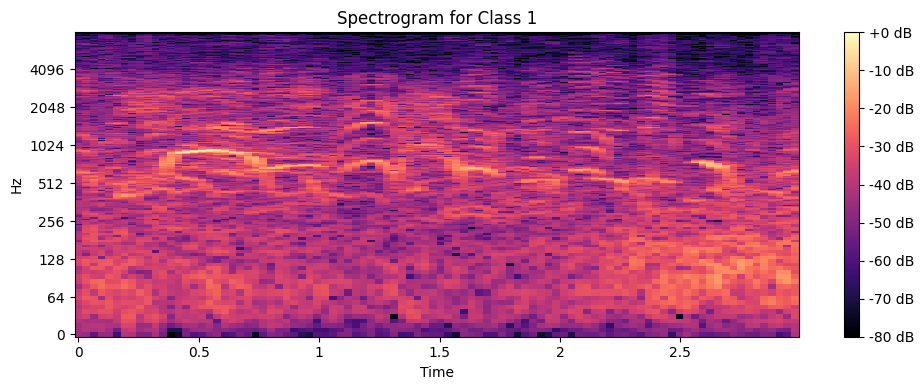

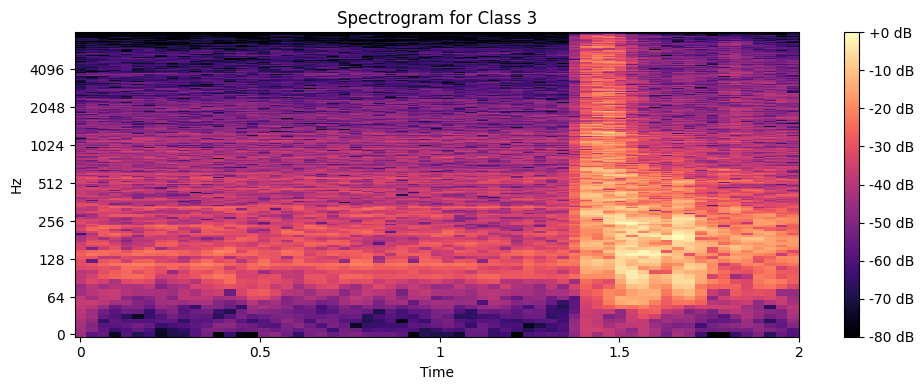

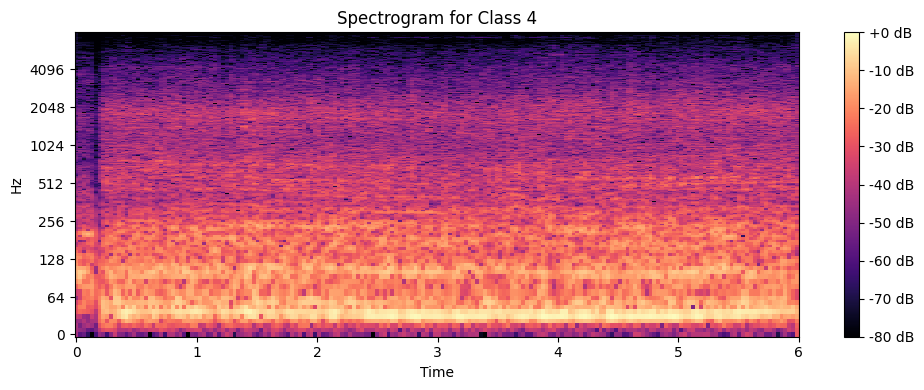

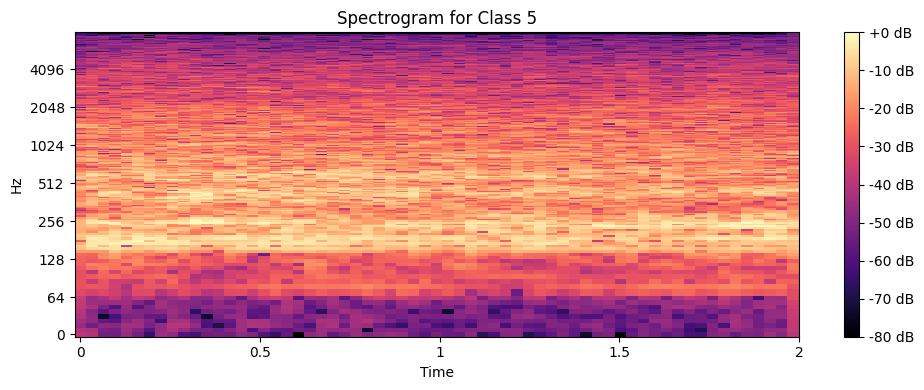

In [8]:
import os

def plot_spectrogram(audio_path, title):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio with its original sample rate
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Correct the paths by removing leading zeros from folder names
def correct_path(path):
    parts = path.split('/')
    corrected_parts = [str(int(part)) if part.isdigit() else part for part in parts]
    return os.path.join("data/MAD_dataset", *corrected_parts)

# Plot a spectrogram for each class
for label in unique_labels:
    sample = train_df[train_df['label'] == label].iloc[0]  # Take the first sample of each class
    corrected_path = correct_path(sample['path'])
    plot_spectrogram(corrected_path, f"Spectrogram for Class {label}")


Visualizing sample audio files...


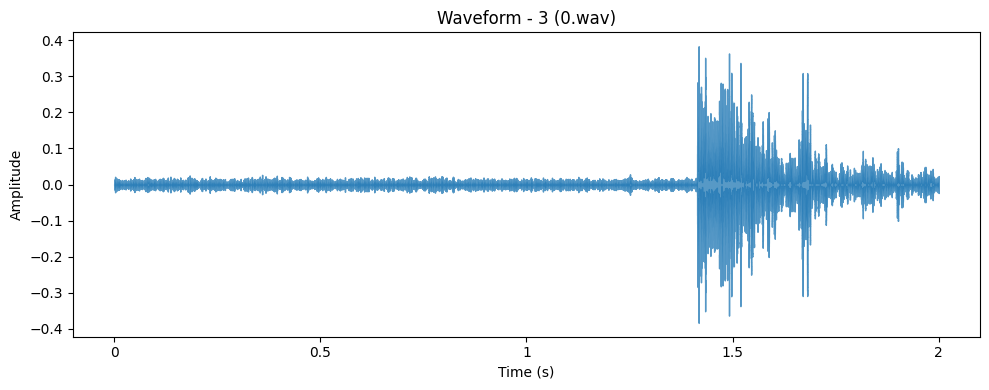

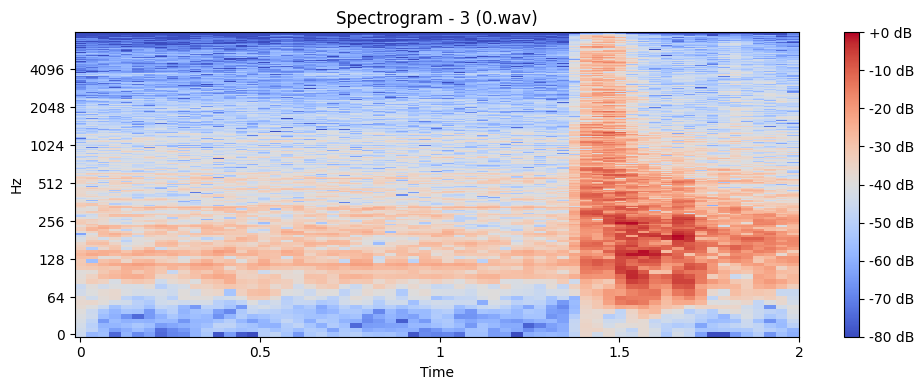

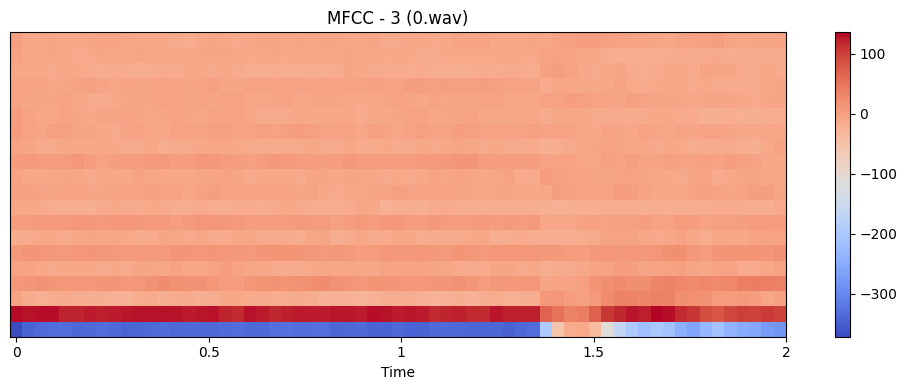

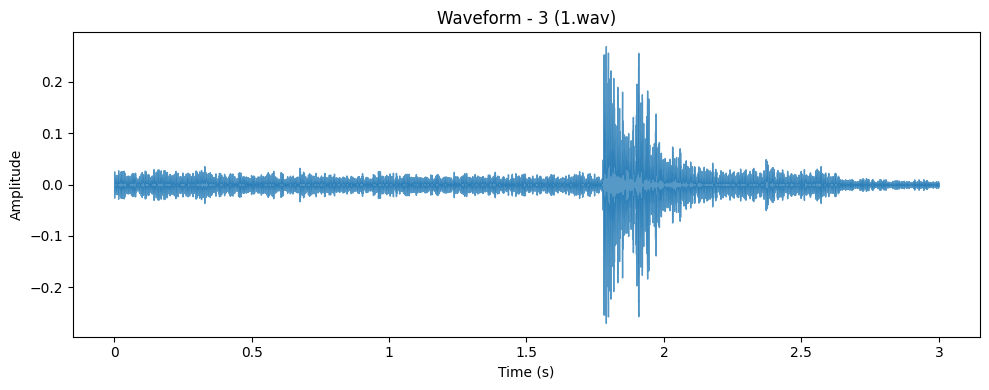

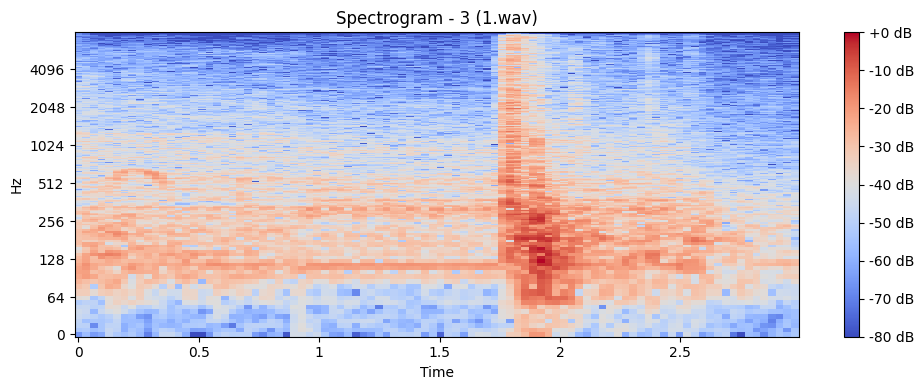

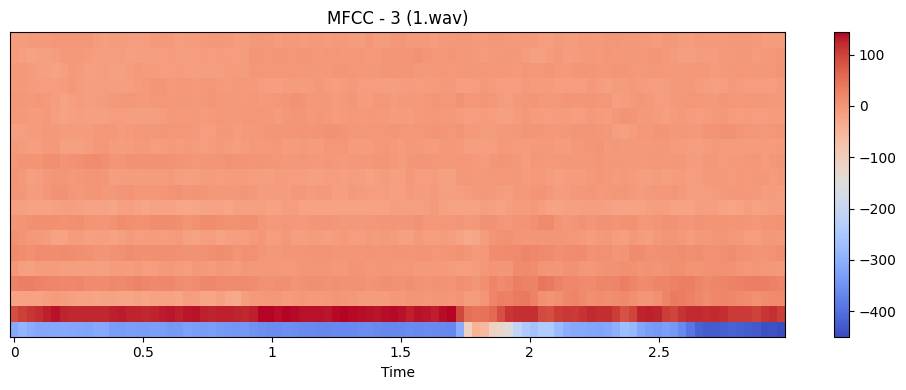

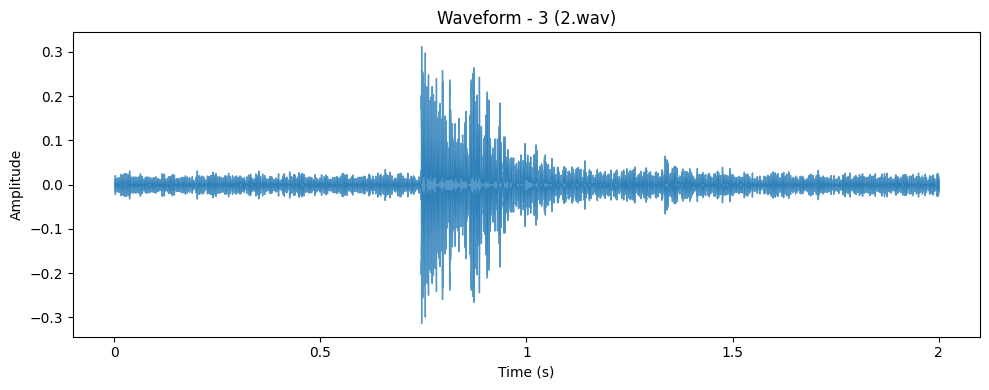

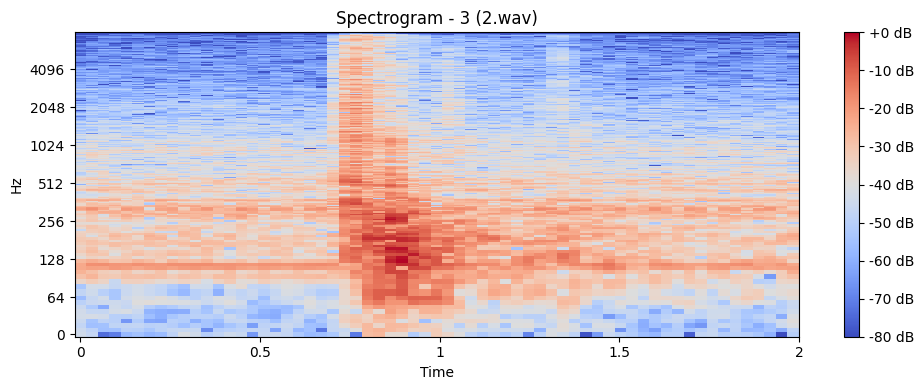

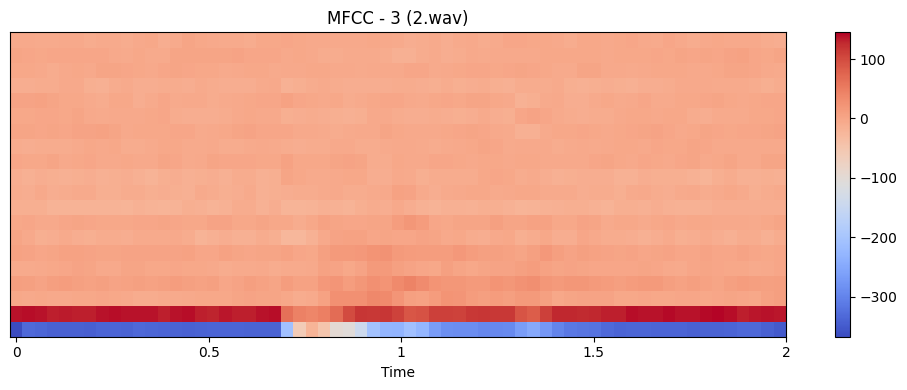

Plotting distribution of audio durations...


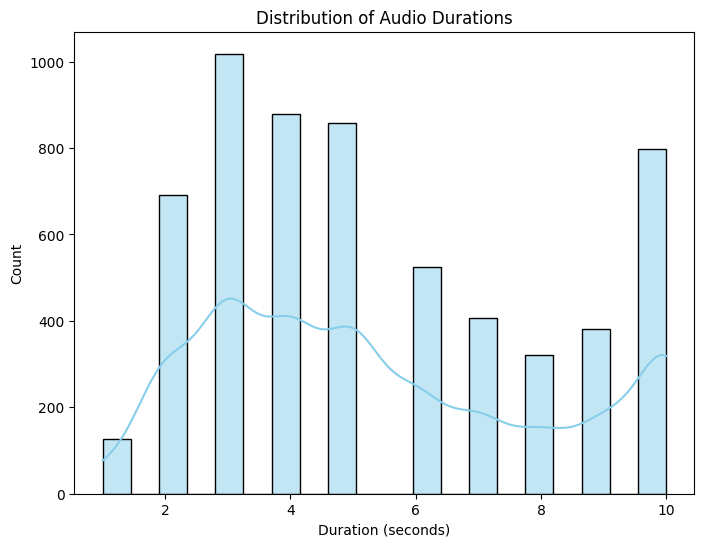

In [3]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
csv_file = 'filtered_training.csv'
df_annotations = pd.read_csv(csv_file)

# Paths
base_path = 'data/MAD_dataset/training'

# Function to plot waveform
def plot_waveform(audio_data, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sr, alpha=0.75)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Function to plot spectrogram
def plot_spectrogram(audio_data, sr, title):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Function to plot MFCCs
def plot_mfcc(audio_data, sr, n_mfcc=20, title='MFCC'):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='coolwarm')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Function to visualize audio duration distribution
def plot_audio_duration_distribution(df_annotations, base_path):
    durations = []
    for index, row in df_annotations.iterrows():
        try:
            path_parts = row['path'].split('/')
            folder_name = path_parts[-2].lstrip('0')  # Adjust folder name
            file_name = path_parts[-1]
            file_path = os.path.join(base_path, folder_name, file_name)
            
            # Load audio file
            audio_data, sr = librosa.load(file_path, sr=None)
            durations.append(len(audio_data) / sr)
        except Exception as e:
            print(f"Error loading file: {file_path}, {e}")
    
    plt.figure(figsize=(8, 6))
    sns.histplot(durations, kde=True, color='skyblue', bins=20)
    plt.title('Distribution of Audio Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.show()

# Plot a few examples from the dataset
def plot_sample_visualizations(df_annotations, base_path, num_samples=3):
    for i, row in df_annotations.head(num_samples).iterrows():
        try:
            path_parts = row['path'].split('/')
            folder_name = path_parts[-2].lstrip('0')  # Adjust folder name
            file_name = path_parts[-1]
            file_path = os.path.join(base_path, folder_name, file_name)
            label = row['label']
            
            # Load audio file
            audio_data, sr = librosa.load(file_path, sr=None)
            
            # Plot waveform
            plot_waveform(audio_data, sr, title=f"Waveform - {label} ({file_name})")
            
            # Plot spectrogram
            plot_spectrogram(audio_data, sr, title=f"Spectrogram - {label} ({file_name})")
            
            # Plot MFCC
            plot_mfcc(audio_data, sr, title=f"MFCC - {label} ({file_name})")
        
        except Exception as e:
            print(f"Error processing file: {file_path}, {e}")

# Call functions for EDA
print("Visualizing sample audio files...")
plot_sample_visualizations(df_annotations, base_path)

print("Plotting distribution of audio durations...")
plot_audio_duration_distribution(df_annotations, base_path)


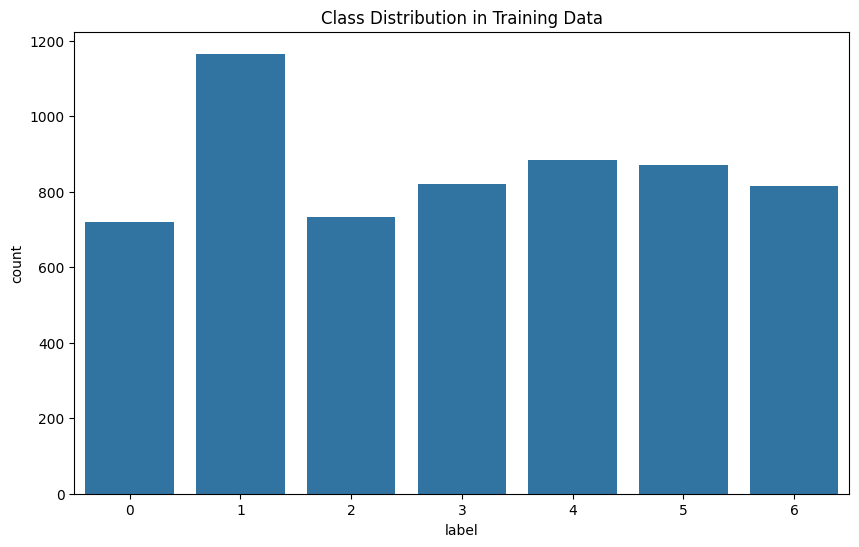

Missing values in training data: 269
Missing values in testing data: 78


In [4]:
# Visualize class distribution in the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label')
plt.title("Class Distribution in Training Data")
plt.show()

# Check for missing values
print("Missing values in training data:", train_df.isnull().sum().sum())
print("Missing values in testing data:", test_df.isnull().sum().sum())


In [29]:
train_df.shape

(5736, 13)

In [10]:
train_df.isnull().sum()

Unnamed: 0         0
path               0
label              0
youtube title      0
youtube url      269
video_num          0
file_id            0
Youtube title      0
Start_time         0
End_time           0
Label              0
url                0
duration           0
dtype: int64

In [30]:
test_df.shape

(882, 12)

In [11]:
test_df.isnull().sum()

Unnamed: 0        0
path              0
label             0
youtube title     0
youtube url      78
video_num         0
file_id           0
Youtube title     0
Start_time        0
End_time          0
Label             0
url               0
dtype: int64

In [12]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [13]:
train_df.isnull().sum()

Unnamed: 0       0
path             0
label            0
youtube title    0
youtube url      0
video_num        0
file_id          0
Youtube title    0
Start_time       0
End_time         0
Label            0
url              0
duration         0
dtype: int64

In [14]:
test_df.isnull().sum()

Unnamed: 0       0
path             0
label            0
youtube title    0
youtube url      0
video_num        0
file_id          0
Youtube title    0
Start_time       0
End_time         0
Label            0
url              0
dtype: int64

In [10]:

import os
import librosa
import numpy as np
import pandas as pd

# Paths
base_path = 'data/MAD_dataset/training'
csv_file = 'filtered_training.csv'  # Adjust path as needed

# Load CSV file with labels and other info
df_annotations = pd.read_csv(csv_file)

# Initialize a list to store features, file names, labels, etc.
data = []

# Function to extract MFCC features with delta and delta-delta
def extract_mfcc_features(file_path, sample_rate=22050, n_mfcc=20):
    try:
        # Load audio file
        audio_data, sr = librosa.load(file_path, sr=sample_rate)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
        
        # Extract delta (first derivative) and delta-delta (second derivative)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        
        # Concatenate original MFCCs with delta and delta-delta
        mfcc_combined = np.concatenate((mfccs, delta_mfccs, delta2_mfccs), axis=0)
        
        # Calculate summary statistics
        mfcc_mean = np.mean(mfcc_combined, axis=1)
        mfcc_var = np.var(mfcc_combined, axis=1)
        mfcc_min = np.min(mfcc_combined, axis=1)
        mfcc_max = np.max(mfcc_combined, axis=1)
        
        # Concatenate all statistics to form a single feature vector
        mfcc_stats = np.concatenate((mfcc_mean, mfcc_var, mfcc_min, mfcc_max), axis=0)
        
        return mfcc_stats
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Loop through each file in the annotations DataFrame
for index, row in df_annotations.iterrows():
    path_parts = row['path'].split('/')  # Split by '/'
    folder_name = path_parts[-2].lstrip('0')  # Second last part is folder_name
    file_name = path_parts[-1]  # Last part is file_name
    
    label = row['label']  # Example column for label
    file_path = os.path.join(base_path, folder_name, file_name)
    
    # Extract features and store with label and other info
    features = extract_mfcc_features(file_path)
    if features is not None:
        data.append([file_name, label, *features])

# Define column names for the DataFrame based on the number of MFCC features
n_mfcc = 20  # Adjust based on `n_mfcc` value used in feature extraction
column_names = ['filename', 'label'] + [f'mfcc_{stat}_{i+1}' for stat in ['mean', 'var', 'min', 'max'] for i in range(n_mfcc * 3)]

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=column_names)

# Save the DataFrame to a CSV file
output_csv = 'training_features_with_labels.csv'
df.to_csv(output_csv, index=False)

print(f"Feature extraction complete. Features with labels saved to {output_csv}.")


KeyboardInterrupt: 

In [ ]:
base_path2 = 'data/MAD_dataset/test'
csv_file2 = 'filtered_testing.csv'
df_annotations2 = pd.read_csv(csv_file2)

# Initialize a list to store features, file names, labels, etc.
data2 = []
for index, row in df_annotations2.iterrows():
    path_parts = row['path'].split('/')  # Split by '/'
    folder_name = path_parts[-2].lstrip('0')  # Second last part is folder_name
    file_name = path_parts[-1]  # Last part is file_name
    
    label = row['label']  # Example column for label
    file_path = os.path.join(base_path2, folder_name, file_name)
    
    # Extract features and store with label and other info
    features = extract_mfcc_features(file_path)
    if features is not None:
        data.append([file_name, label, *features])

n_mfcc = 20 # Adjust based on `n_mfcc` value used in feature extraction
column_names = ['filename', 'label'] + [f'mfcc_{stat}_{i+1}' for stat in ['mean', 'var', 'min', 'max'] for i in range(n_mfcc * 3)]

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=column_names)

# Save the DataFrame to a CSV file
output_csv2 = 'testing_features_with_labels.csv'
df.to_csv(output_csv2, index=False)

print(f"Feature extraction complete. Features with labels saved to {output_csv2}.")

Feature extraction complete. Features with labels saved to testing_features_with_labels.csv.


In [15]:
final_train_df = pd.read_csv("training_features_with_labels.csv")
final_test_df = pd.read_csv("testing_features_with_labels.csv")

In [31]:
final_train_df.head()

,filename,label,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mfcc_max_51,mfcc_max_52,mfcc_max_53,mfcc_max_54,mfcc_max_55,mfcc_max_56,mfcc_max_57,mfcc_max_58,mfcc_max_59,mfcc_max_60
0,0.wav,3,-330.27910,152.65192,-29.824821,38.550644,-22.235832,21.921467,-11.786571,3.817423,...,1.255147,1.192969,1.129980,2.041515,1.170684,1.875802,1.647185,1.033560,0.899866,1.333885
1,1.wav,3,-367.41003,152.75040,-19.659775,37.794620,-16.290888,21.079048,-12.578966,6.477196,...,1.457993,1.718543,1.023075,2.102301,1.424144,1.477711,1.193758,1.628727,1.090485,1.238507
2,2.wav,3,-334.69280,158.02672,-17.986649,37.812607,-19.661316,24.043741,-15.877230,7.140943,...,1.496059,0.721778,0.909306,1.233423,1.183785,1.562762,1.015739,1.777341,0.795219,0.793252
3,3.wav,3,-334.58984,140.55904,-39.669620,38.682053,-24.210623,25.699870,-15.211676,10.201726,...,0.963980,1.477645,0.941608,1.295401,1.377096,1.244936,1.347400,0.871460,0.919143,0.793787
4,4.wav,3,-355.70517,149.90692,-28.147085,36.761883,-28.368877,21.502703,-16.964622,3.667777,...,1.341818,1.263314,0.715865,1.785772,0.864746,1.735922,0.820773,1.112392,0.650718,1.008151


In [ ]:
final_train_df.shape

(6005, 242)

In [17]:
final_train_df.isnull().sum()

filename       0
label          0
mfcc_mean_1    0
mfcc_mean_2    0
mfcc_mean_3    0
              ..
mfcc_max_56    0
mfcc_max_57    0
mfcc_max_58    0
mfcc_max_59    0
mfcc_max_60    0
Length: 242, dtype: int64

In [18]:
X_train = final_train_df.drop(columns=["filename", "label"]).values
y_train = final_train_df["label"].values

X_test = final_test_df.drop(columns=["filename", "label"]).values
y_test = final_test_df["label"].values

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

num_classes = len(np.unique(y_train))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [35]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [34]:
X_train

array([[-0.88826974, -0.01904866,  0.90894696, ..., -0.89829291,
        -1.01001029, -0.27161056],
       [-1.20035589, -0.01632051,  1.27296069, ...,  0.07910849,
        -0.70054769, -0.4249752 ],
       [-0.92536697,  0.12984703,  1.33287589, ...,  0.32316682,
        -1.17990105, -1.14092894],
       ...,
       [ 1.04081985,  0.44070931,  0.02282497, ..., -0.83085836,
        -0.1668773 , -0.81655628],
       [ 1.01967098,  0.34376865, -0.1362637 , ..., -0.13459288,
        -0.48189781, -0.56831979],
       [ 0.65487099,  0.7235981 ,  0.38290038, ..., -0.59996498,
        -1.14378168, -0.89932289]])


Training Random Forest...
Random Forest Accuracy (Train): 0.9985012489592007
Random Forest Accuracy (Test): 0.937975592246949
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       923
           1       0.92      0.92      0.92      1427
           2       0.96      0.95      0.96       830
           3       0.94      0.95      0.94       903
           4       0.94      0.95      0.94       991
           5       0.92      0.96      0.94       947
           6       0.98      0.97      0.98       944

    accuracy                           0.94      6965
   macro avg       0.94      0.94      0.94      6965
weighted avg       0.94      0.94      0.94      6965



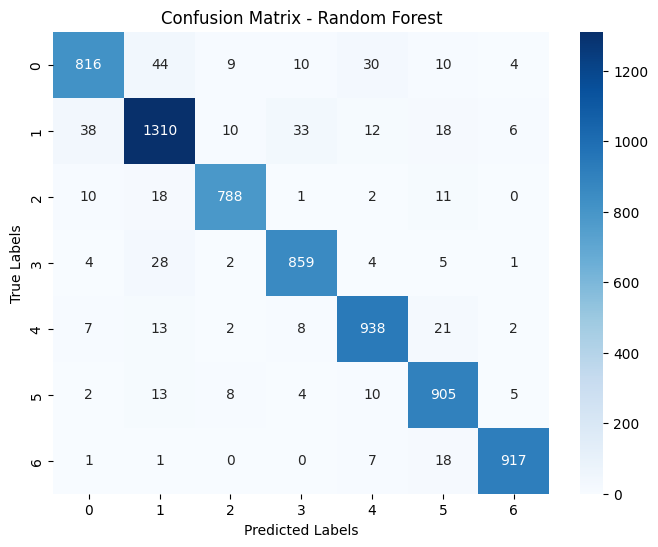


Training Logistic Regression...
Logistic Regression Accuracy (Train): 0.7002497918401333
Logistic Regression Accuracy (Test): 0.6770997846374731
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       923
           1       0.63      0.62      0.63      1427
           2       0.69      0.71      0.70       830
           3       0.73      0.73      0.73       903
           4       0.67      0.67      0.67       991
           5       0.57      0.65      0.61       947
           6       0.84      0.86      0.85       944

    accuracy                           0.68      6965
   macro avg       0.68      0.68      0.68      6965
weighted avg       0.68      0.68      0.68      6965



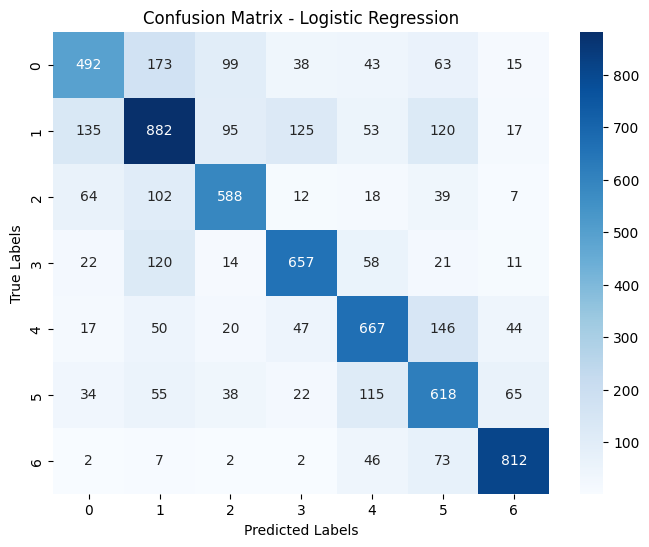


Training SVM (RBF Kernel)...
SVM (RBF Kernel) Accuracy (Train): 0.7925062447960033
SVM (RBF Kernel) Accuracy (Test): 0.7628140703517587
Classification Report (SVM (RBF Kernel)):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       923
           1       0.72      0.77      0.75      1427
           2       0.77      0.79      0.78       830
           3       0.84      0.77      0.81       903
           4       0.75      0.76      0.75       991
           5       0.66      0.74      0.70       947
           6       0.92      0.86      0.89       944

    accuracy                           0.76      6965
   macro avg       0.77      0.76      0.77      6965
weighted avg       0.77      0.76      0.76      6965



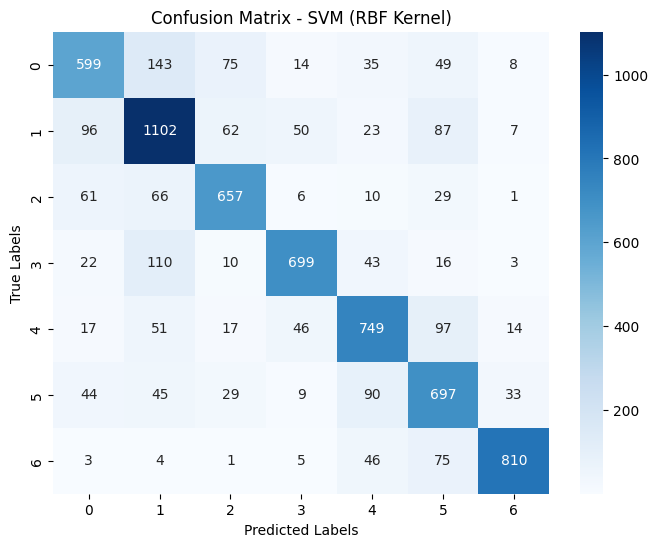


Training K-Nearest Neighbors...
K-Nearest Neighbors Accuracy (Train): 0.7372189841798501
K-Nearest Neighbors Accuracy (Test): 0.7015075376884422
Classification Report (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       923
           1       0.67      0.65      0.66      1427
           2       0.67      0.73      0.70       830
           3       0.78      0.67      0.72       903
           4       0.79      0.66      0.72       991
           5       0.59      0.76      0.66       947
           6       0.85      0.84      0.85       944

    accuracy                           0.70      6965
   macro avg       0.71      0.71      0.71      6965
weighted avg       0.71      0.70      0.70      6965



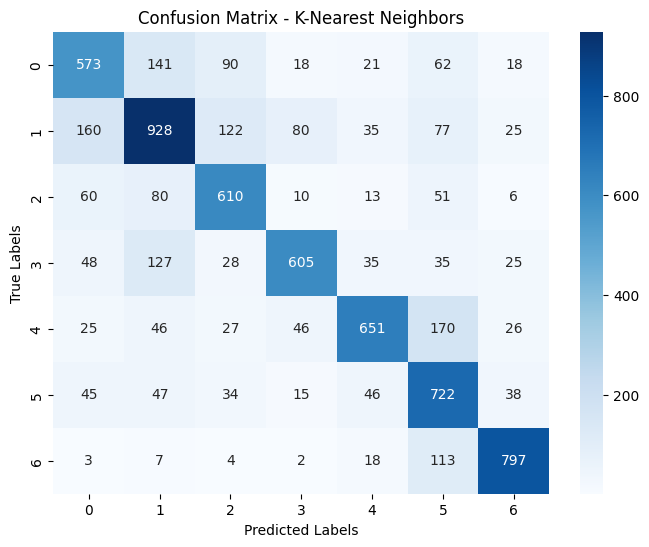


Training XGBoost...


C:\Users\P.Harshvardhini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [15:04:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (Train): 0.9985012489592007
XGBoost Accuracy (Test): 0.9398420674802584
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       923
           1       0.92      0.92      0.92      1427
           2       0.96      0.95      0.95       830
           3       0.95      0.96      0.96       903
           4       0.94      0.94      0.94       991
           5       0.91      0.96      0.94       947
           6       0.98      0.97      0.97       944

    accuracy                           0.94      6965
   macro avg       0.94      0.94      0.94      6965
weighted avg       0.94      0.94      0.94      6965



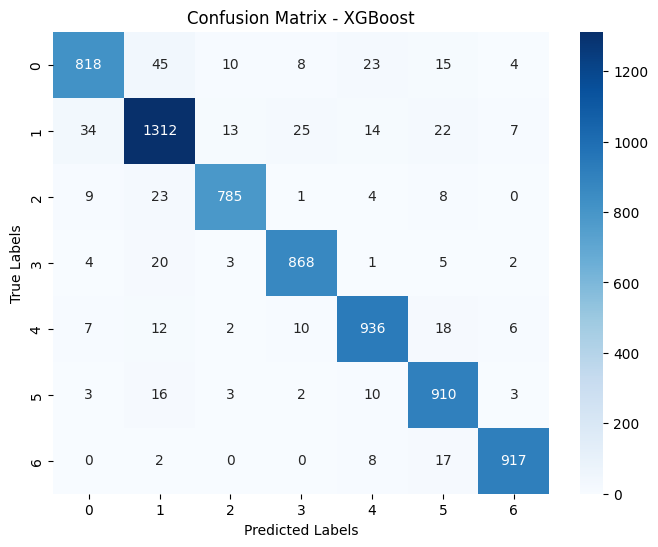


Training MLP...
MLP Accuracy (Train): 0.9985012489592007
MLP Accuracy (Test): 0.9283560660445083
Classification Report (MLP):
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       923
           1       0.92      0.90      0.91      1427
           2       0.91      0.94      0.93       830
           3       0.95      0.95      0.95       903
           4       0.93      0.94      0.94       991
           5       0.91      0.95      0.93       947
           6       0.99      0.96      0.97       944

    accuracy                           0.93      6965
   macro avg       0.93      0.93      0.93      6965
weighted avg       0.93      0.93      0.93      6965



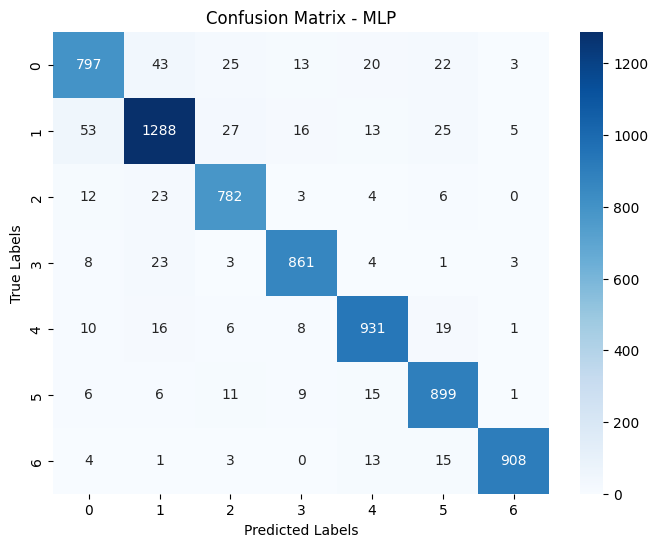


Final Model Comparison:
Model                Accuracy   Precision  Recall     F1-Score  
Random Forest        0.937976    0.938146    0.937976    0.937911
Logistic Regression  0.677100    0.677448    0.677100    0.676174
SVM (RBF Kernel)     0.762814    0.766611    0.762814    0.763738
K-Nearest Neighbors  0.701508    0.710216    0.701508    0.702594
XGBoost              0.939842    0.940047    0.939842    0.939766
MLP                  0.928356    0.928499    0.928356    0.928265


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train the model
    model.fit(X_train, np.argmax(y_train, axis=1))  # Use non-one-hot labels

    # Predict on test set
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to integer labels

    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)

    # Evaluate performance
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{name} Accuracy (Train): {train_accuracy}")
    print(f"{name} Accuracy (Test): {accuracy}")
    print(f"Classification Report ({name}):")
    print(classification_report(y_true, y_pred))

    # Store results
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "y_pred": y_pred
    }

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Final Summary of Results
print("\nFinal Model Comparison:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
for name, result in results.items():
    print(f"{name:<20} {result['accuracy']:.6f}    {result['precision']:.6f}    {result['recall']:.6f}    {result['f1_score']:.6f}")


In [40]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# models = {
#     "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
#     "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True, random_state=42),
#     "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
#     "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
# }

# # Train and evaluate each model
# results = {}

# for name, model in models.items():
#     print(f"\nTraining {name}...")
#     # Train the model
#     model.fit(X_train, np.argmax(y_train, axis=1))  # Use non-one-hot labels
    
#     # Predict on test set
#     y_pred = model.predict(X_test)
#     y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to integer labels
    
#     # Evaluate performance
#     accuracy = accuracy_score(y_true, y_pred)
#     print(f"{name} Accuracy: {accuracy}")
#     print(f"Classification Report ({name}):")
#     print(classification_report(y_true, y_pred))
    
#     # Store results
#     results[name] = {
#         "model": model,
#         "accuracy": accuracy,
#         "y_pred": y_pred
#     }
    
#     # Confusion Matrix
#     conf_matrix = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
#     plt.title(f'Confusion Matrix - {name}')
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.show()

# # Compare Results
# print("\nModel Comparison:")
# for name, result in results.items():
#     print(f"{name}: Accuracy = {result['accuracy']:.2f}")


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the ANN model
def build_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the model
ann_model = build_ann_model(X_train.shape[1], num_classes)
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
ann_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


C:\Users\P.Harshvardhini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.3638 - loss: 1.7835 - val_accuracy: 0.6201 - val_loss: 1.1635
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5655 - loss: 1.2558 - val_accuracy: 0.6441 - val_loss: 1.0853
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6008 - loss: 1.1720 - val_accuracy: 0.6547 - val_loss: 1.0340
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6245 - loss: 1.0911 - val_accuracy: 0.6849 - val_loss: 0.9903
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6540 - loss: 1.0583 - val_accuracy: 0.6893 - val_loss: 0.9698
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6670 - loss: 1.0178 - val_accuracy: 0.6995 - val_loss: 0.9349
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6726 - loss: 0.9718 - val_accuracy: 0.7163 - val_loss: 0.9055
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6825 - loss: 0.9565 - val_acc

In [22]:
# Evaluate the model
loss, accuracy = ann_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


218/218 - 2s - 10ms/step - accuracy: 0.8085 - loss: 0.6075
Test Loss: 0.6075
Test Accuracy: 0.8085


In [26]:
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D

# Reshape the data for CNN (if needed)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# Define the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the model
cnn_model = build_cnn_model(X_train_cnn.shape[1:], num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_cnn, y_train, epochs=30, batch_size=32, validation_data=(X_test_cnn, y_test))


C:\Users\P.Harshvardhini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.3859 - loss: 1.6144 - val_accuracy: 0.5981 - val_loss: 1.2140
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5853 - loss: 1.2379 - val_accuracy: 0.6501 - val_loss: 1.1000
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6256 - loss: 1.1263 - val_accuracy: 0.6640 - val_loss: 1.0415
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6525 - loss: 1.0542 - val_accuracy: 0.6791 - val_loss: 0.9928
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.6609 - loss: 1.0318 - val_accuracy: 0.6905 - val_loss: 0.9350
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.6633 - loss: 0.9704 - val_accuracy: 0.6949 - val_loss: 0.9072
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.6883 - loss: 0.9290 - val_accuracy: 0.7269 - val_loss: 0.8428
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.7050 - loss: 0.8801 - v

In [27]:
# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=2)

print(f"Test Loss (CNN): {cnn_loss:.4f}")
print(f"Test Accuracy (CNN): {cnn_accuracy:.4f}")


218/218 - 3s - 15ms/step - accuracy: 0.9068 - loss: 0.4670
Test Loss (CNN): 0.4670
Test Accuracy (CNN): 0.9068


In [28]:
from tensorflow.keras.layers import LSTM

# Reshape the data for RNN
X_train_rnn = X_train[..., np.newaxis]
X_test_rnn = X_test[..., np.newaxis]

# Define the RNN model
def build_rnn_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the model
rnn_model = build_rnn_model(X_train_rnn.shape[1:], num_classes)
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_rnn, y_train, epochs=30, batch_size=32, validation_data=(X_test_rnn, y_test))


C:\Users\P.Harshvardhini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 162s 780ms/step - accuracy: 0.2545 - loss: 1.7910 - val_accuracy: 0.3459 - val_loss: 1.6401
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 127s 676ms/step - accuracy: 0.3256 - loss: 1.6571 - val_accuracy: 0.3621 - val_loss: 1.6153
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 136s 724ms/step - accuracy: 0.3437 - loss: 1.6319 - val_accuracy: 0.3632 - val_loss: 1.6140
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 293ms/step - accuracy: 0.3647 - loss: 1.6077 - val_accuracy: 0.3803 - val_loss: 1.5681
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - accuracy: 0.3770 - loss: 1.5518 - val_accuracy: 0.4123 - val_loss: 1.5243
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 244ms/step - accuracy: 0.4161 - loss: 1.5167 - val_accuracy: 0.4204 - val_loss: 1.5164
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.4025 - loss: 1.5170 - val_accuracy: 0.4083 - val_loss: 1.5142
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 226ms/step - accuracy: 0.4319 - loss

In [30]:
import os
import librosa
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

# Paths
base_path = 'data/MAD_dataset/training'
csv_file = 'filtered_training.csv'  # Adjust path as needed

# Load CSV file with labels and other info
df_annotations = pd.read_csv(csv_file)

# Initialize a list to store features, file names, labels, etc.
train_spectrograms = []
train_labels = []

# Function to generate Mel-spectrograms
def generate_spectrogram(file_path, image_size=(64, 64)):
    audio, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spec_resized = np.resize(log_mel_spec, image_size)
    return log_mel_spec_resized

# Function to check if the file exists
def file_exists(file_path):
    return os.path.exists(file_path)

# Loop through each file in the annotations DataFrame
for index, row in df_annotations.iterrows():
    path_parts = row['path'].split('/')  # Split by '/'
    folder_name = path_parts[-2].lstrip('0')  # Strip leading zeros from folder name
    file_name = path_parts[-1]  # Last part is file_name
    
    label = row['label']  # Example column for label
    file_path = os.path.join(base_path, folder_name, file_name)
    
    # Check if the file exists
    if file_exists(file_path):
        try:
            # Generate spectrograms for audio files
            spec = generate_spectrogram(file_path)
            train_spectrograms.append(spec)
            train_labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    else:
        print(f"File not found: {file_path}")

# Convert to numpy arrays
X_train = np.array(train_spectrograms)
y_train = np.array(train_labels)

# Normalize spectrograms
X_train = X_train / np.max(X_train)

# Add channel dimension
X_train = X_train[..., np.newaxis]

# Encode labels for training data
num_classes = len(df_annotations['label'].unique())  # Adjust based on the actual number of classes
y_train = to_categorical(y_train, num_classes=num_classes)

print(f"Training data shape: {X_train.shape}")


Training data shape: (6005, 64, 64, 1)


In [38]:
import os
import librosa
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

# Paths
base_path2 = 'data/MAD_dataset/test'  # Assuming testing data is in the 'testing' folder
csv_file = 'filtered_testing.csv'  # Adjust the path if needed

# Load CSV file with labels and other info
df_annotations_test = pd.read_csv(csv_file)

# Initialize a list to store features, file names, labels, etc.
test_spectrograms = []
test_labels = []

# Function to generate Mel-spectrograms
# def generate_spectrogram(file_path, image_size=(64, 64)):
#     audio, sr = librosa.load(file_path, sr=None)
#     mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
#     log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
#     log_mel_spec_resized = np.resize(log_mel_spec, image_size)
#     return log_mel_spec_resized

# Function to check if the file exists
# def file_exists(file_path):
#     return os.path.exists(file_path)

# Loop through each file in the annotations DataFrame (for the test set)
for index, row in df_annotations_test.iterrows():
    path_parts = row['path'].split('/')  # Split by '/'
    folder_name = path_parts[-2].lstrip('0')  # Strip leading zeros from folder name
    file_name = path_parts[-1]  # Last part is file_name
    
    label = row['label']  # Example column for label
    file_path = os.path.join(base_path2, folder_name, file_name)
    
    # Check if the file exists
    if file_exists(file_path):
        try:
            # Generate spectrograms for audio files
            spec = generate_spectrogram(file_path)
            test_spectrograms.append(spec)
            test_labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    else:
        print(f"File not found: {file_path}")

# Convert to numpy arrays
X_test = np.array(test_spectrograms)
y_test = np.array(test_labels)

# Normalize spectrograms
X_test = X_test / np.max(X_test)

# Add channel dimension
X_test = X_test[..., np.newaxis]

# Encode labels for testing data
num_classes = len(df_annotations_test['label'].unique())  # Adjust based on the actual number of classes
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"Test data shape: {X_test.shape}")


Test data shape: (960, 64, 64, 1)


C:\Users\P.Harshvardhini\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 231ms/step - accuracy: 0.2674 - loss: 2.3890 - val_accuracy: 0.3792 - val_loss: 2.4689 - learning_rate: 0.0010
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 230ms/step - accuracy: 0.3563 - loss: 1.8939 - val_accuracy: 0.3500 - val_loss: 2.0981 - learning_rate: 0.0010
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 229ms/step - accuracy: 0.4042 - loss: 1.6680 - val_accuracy: 0.3979 - val_loss: 2.2148 - learning_rate: 0.0010
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.4249 - loss: 1.6273 - val_accuracy: 0.3927 - val_loss: 2.3487 - learning_rate: 0.0010
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.4536 - loss: 1.5483 - val_accuracy: 0.3812 - val_loss: 2.0847 - learning_rate: 0.0010
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.4674 - loss: 1.5036 - val_accuracy: 0.3885 - val_loss: 2.2051 - learning_rate: 0.0010
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.4

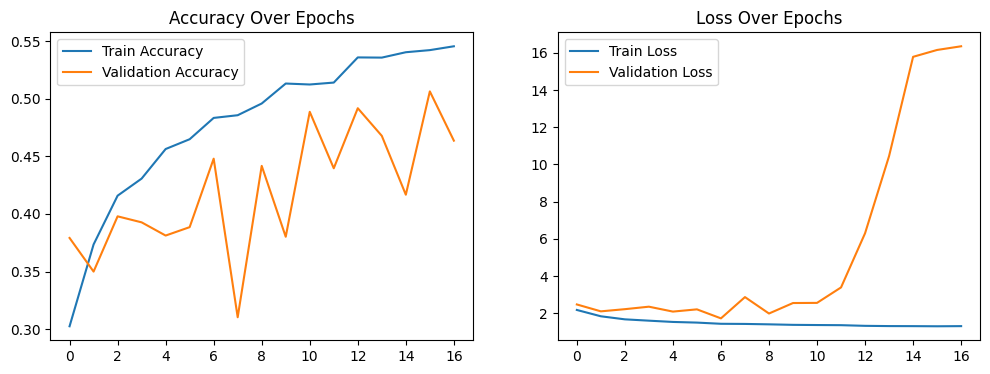

In [40]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Normalize data and add channel dimension
# X_train = X_train / 255.0
# X_test = X_test / 255.0
# X_train = X_train[..., np.newaxis]
# X_test = X_test[..., np.newaxis]

# # Get the number of classes
# num_classes = len(np.unique(y_train))

# # Convert labels to categorical
# y_train = to_categorical(y_train, num_classes=num_classes)
# y_test = to_categorical(y_test, num_classes=num_classes)

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)  # Ensure the generator fits the training data

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model using data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()
